# Importing Libraries

In [ ]:
# For pytorch operations
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm.autonotebook import tqdm
from torchsummary import summary

import matplotlib.pyplot as plt # for ploting the results
import numpy as np # for mathematical work

# Importing Dataset

In [ ]:
torch.manual_seed(1)
batch_size = 128 # batch size
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# For training set
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, #create directory and give the path, True for training set, download if dataset is not available in local storage
                    transform=transforms.Compose([
                        transforms.ToTensor(), # Convert image to tensor
                        transforms.Normalize((0.1307,), (0.3081,)) # Normalize image with mean and standard deviation
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


# For testing set
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False,  # create the directory for testing dataset, train is false for testing 
                   transform=transforms.Compose([ 
                        transforms.ToTensor(), # Convert image to tensor
                        transforms.Normalize((0.1307,), (0.3081,)) # Normalize the data
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Data Vizualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


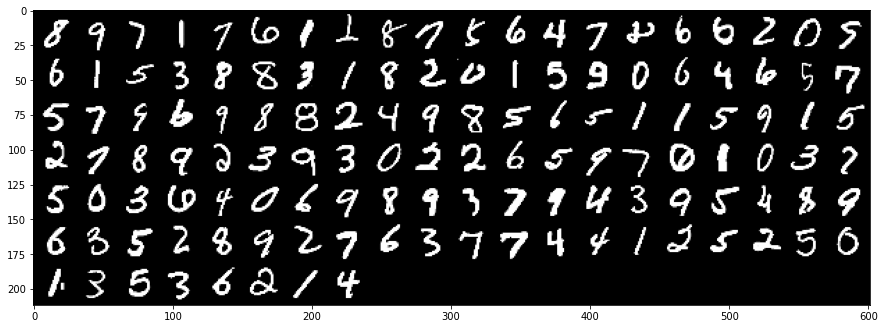

In [ ]:
from torchvision.utils import make_grid # For making the grid
batch = next(iter(train_loader))   # Accesing batch
images, labels = batch 

grid = make_grid(images, nrow=20);    # Creating grid of images
plt.figure(figsize=(15,15)); # figure size of 15x15
plt.imshow(np.transpose(grid, (1,2,0)));

# Model Architecture

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        drop = 0.1 # droput value (drop 10% neurons)
        #Block 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1, bias=False),  # input: 28x28x1 output: 28x28x8 RF:3x3
            nn.ReLU(), # activation function relu
            nn.BatchNorm2d(8), # Batch normalization

            nn.Conv2d(8, 16, 3,padding=1, bias=False), # input: 28x28x8 output: 28x28x16 RF:5x5
            nn.ReLU(), # activation function relu    
            nn.BatchNorm2d(16), # batchnormalization
            nn.Conv2d(16, 24, 3, padding=1, bias=False), # input: 28x28x16 output: 28x28x24 RF:7x7
            nn.ReLU(), # activation function
            nn.BatchNorm2d(24), # batch normalization
            nn.MaxPool2d(2, 2), # input: 28x28x24 output: 14x14x24 RF:14x14
            nn.Dropout2d(drop) # drop out
        )

        #Transition Block 1x1
        self.trans1 = nn.Sequential(
            nn.Conv2d(24, 8, 1,bias=False), # input: 14x14x24 output: 14x14x8 RF:14x14
            nn.ReLU() # activation function
        )
        #Block 2
        self.conv2 =  nn.Sequential(
            nn.Conv2d(8, 16, 3,bias=False), # input: 14x14x8 output: 12x12x16 RF:16x16
            nn.ReLU(), # activation function
            nn.BatchNorm2d(16), # batch normalization
            nn.Conv2d(16, 32, 3,bias=False),  # input: 12x12x16 output: 10x10x32 RF:18x18
            nn.ReLU(), # activation function
            nn.BatchNorm2d(32), # batch normalization
            nn.Dropout2d(drop), # dropout
        )

        #Transition Block (1x1)
        self.trans2 = nn.Sequential(
            nn.Conv2d(32, 8, 1,bias=False), # input: 10x10x32 output: 10x10x8 RF:18x18
            nn.ReLU() # activation function
        )

        #Block 3
        self.conv3 = nn.Sequential(
            nn.Conv2d(8, 16, 3,bias=False), # input: 10x10x8, output: 8x8x16 RF: 20x20 
            nn.ReLU(), # activation function
            nn.BatchNorm2d(16), # batch normalization
            nn.Conv2d(16, 32, 3,bias=False), # # input: 8x8x16 output: 6x6x32 RF:22x22
            nn.ReLU(), # activation function
            nn.BatchNorm2d(32), # batch normalization
            nn.Dropout2d(drop) # dropout
        )

        #GAP Layer
        self.gap = nn.Sequential(
            nn.AvgPool2d(6) # Global average pooling
        )
        #Fully Connected Layer
        self.dense = nn.Linear(32, 10) # 32 input neurons connected with 10 output neurons

    def forward(self, x):
        x = self.conv1(x) # input in conv1 block
        x = self.trans1(x) # input in trnasition block 1
        x = self.conv2(x) # input in conv2 block
        x = self.trans2(x) # input in transition block 2
        x = self.conv3(x) # input in conv3 block

        x = self.gap(x) # global average pooling
        
        x = x.view(-1,32) # reshape 2d tensor to 1d 
        
        x = self.dense(x) # Linear layer
        return F.log_softmax(x,dim=1) # final prediction

# Summary of model

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28)) # putting the input size

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
            Conv2d-4           [-1, 16, 28, 28]           1,152
              ReLU-5           [-1, 16, 28, 28]               0
       BatchNorm2d-6           [-1, 16, 28, 28]              32
            Conv2d-7           [-1, 24, 28, 28]           3,456
              ReLU-8           [-1, 24, 28, 28]               0
       BatchNorm2d-9           [-1, 24, 28, 28]              48
        MaxPool2d-10           [-1, 24, 14, 14]               0
        Dropout2d-11           [-1, 24, 14, 14]               0
           Conv2d-12            [-1, 8, 14, 14]             192
             ReLU-13            [-1, 8, 14, 14]               0
           Conv2d-14           [-1, 16,

# Loss functions and optimization

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    print(f'Epoch:{epoch+1}')
    model.train() # training model
    pbar = tqdm(train_loader)
    t_acc = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # optimizer
        output = model(data) # output of the model
        loss = F.nll_loss(output, target) # calculate the loss
        loss.backward() # backpropogation
        optimizer.step() # optimization

        pred = output.argmax(dim=1).eq(target).sum().item() # final prediction
        t_acc += pred # accuracy
        pbar.set_description(desc= f'loss={loss.item():.4f} batch_id={batch_idx}') # setting the output
    
    return loss.item(), t_acc / len(train_loader.dataset)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data) # output of the model
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    # printing the loss and accuracy of test
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return test_loss, correct/len(test_loader.dataset)

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.015, momentum=0.9) # SGD optimizer
num_epoch = 20 # number of epochs

# defining the dictionary for train and test, loss and accuracy
h = dict() 
h['train_loss'] = list()
h['train_accuracy'] = list()
h['test_loss'] = list()
h['test_accuracy'] = list()


for epoch in range(num_epoch):
    train_loss, train_acc = train(model, device, train_loader, optimizer, epoch) # calling the training
    test_loss, test_acc = test(model, device, test_loader) # calling the testing

    h['train_loss'].append(train_loss) # storing the training loss
    h['train_accuracy'].append(train_acc) # storing  the accuracy

    h['test_loss'].append(test_loss) # storing the testing loss
    h['test_accuracy'].append(test_acc) # storing the testing accuracy


Epoch:1



Test set: Average loss: 0.0546, Accuracy: 9833/10000 (98.33%)

Epoch:2



Test set: Average loss: 0.0544, Accuracy: 9833/10000 (98.33%)

Epoch:3



Test set: Average loss: 0.0334, Accuracy: 9890/10000 (98.90%)

Epoch:4



Test set: Average loss: 0.0322, Accuracy: 9892/10000 (98.92%)

Epoch:5



Test set: Average loss: 0.0348, Accuracy: 9887/10000 (98.87%)

Epoch:6



Test set: Average loss: 0.0258, Accuracy: 9924/10000 (99.24%)

Epoch:7



Test set: Average loss: 0.0252, Accuracy: 9916/10000 (99.16%)

Epoch:8



Test set: Average loss: 0.0255, Accuracy: 9916/10000 (99.16%)

Epoch:9



Test set: Average loss: 0.0272, Accuracy: 9913/10000 (99.13%)

Epoch:10


Test set: Average loss: 0.0261, Accuracy: 9924/10000 (99.24%)

Epoch:11



Test set: Average loss: 0.0208, Accuracy: 9935/10000 (99.35%)

Epoch:12



Test set: Average loss: 0.0198, Accuracy: 9940/10000 (99.40%)

Epoch:13



Test set: Average loss: 0.0219, Accuracy: 9937/10000 (99.37%)

Epoch:14



Test set: Average loss: 0.0213, Accuracy: 9936/10000 (99.36%)

Epoch:15



Test set: Average loss: 0.0197, Accuracy: 9938/10000 (99.38%)

Epoch:16



Test set: Average loss: 0.0201, Accuracy: 9938/10000 (99.38%)

Epoch:17



Test set: Average loss: 0.0210, Accuracy: 9935/10000 (99.35%)

Epoch:18



Test set: Average loss: 0.0200, Accuracy: 9939/10000 (99.39%)

Epoch:19



Test set: Average loss: 0.0206, Accuracy: 9934/10000 (99.34%)

Epoch:20



Test set: Average loss: 0.0185, Accuracy: 9950/10000 (99.50%)



# plotting the results

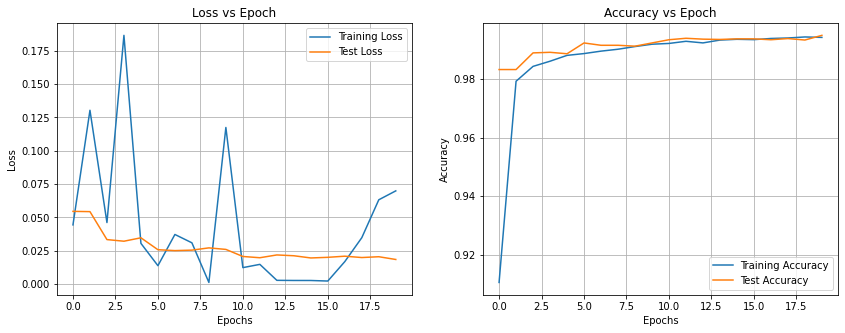

In [ ]:
# For loss and epochs
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(h['train_loss'], label='Training Loss') # plotting the training loss
plt.plot(h['test_loss'], label='Test Loss') # plotting the testing loss
# putting the labels on plot
plt.title('Loss vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

# For accuracy and epochs
plt.subplot(1,2,2)
plt.plot(h['train_accuracy'], label='Training Accuracy') # plotting the training accuracy
plt.plot(h['test_accuracy'], label='Test Accuracy') # plotting the testing accuracy
# putting the labels in plot
plt.title('Accuracy vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

plt.show()

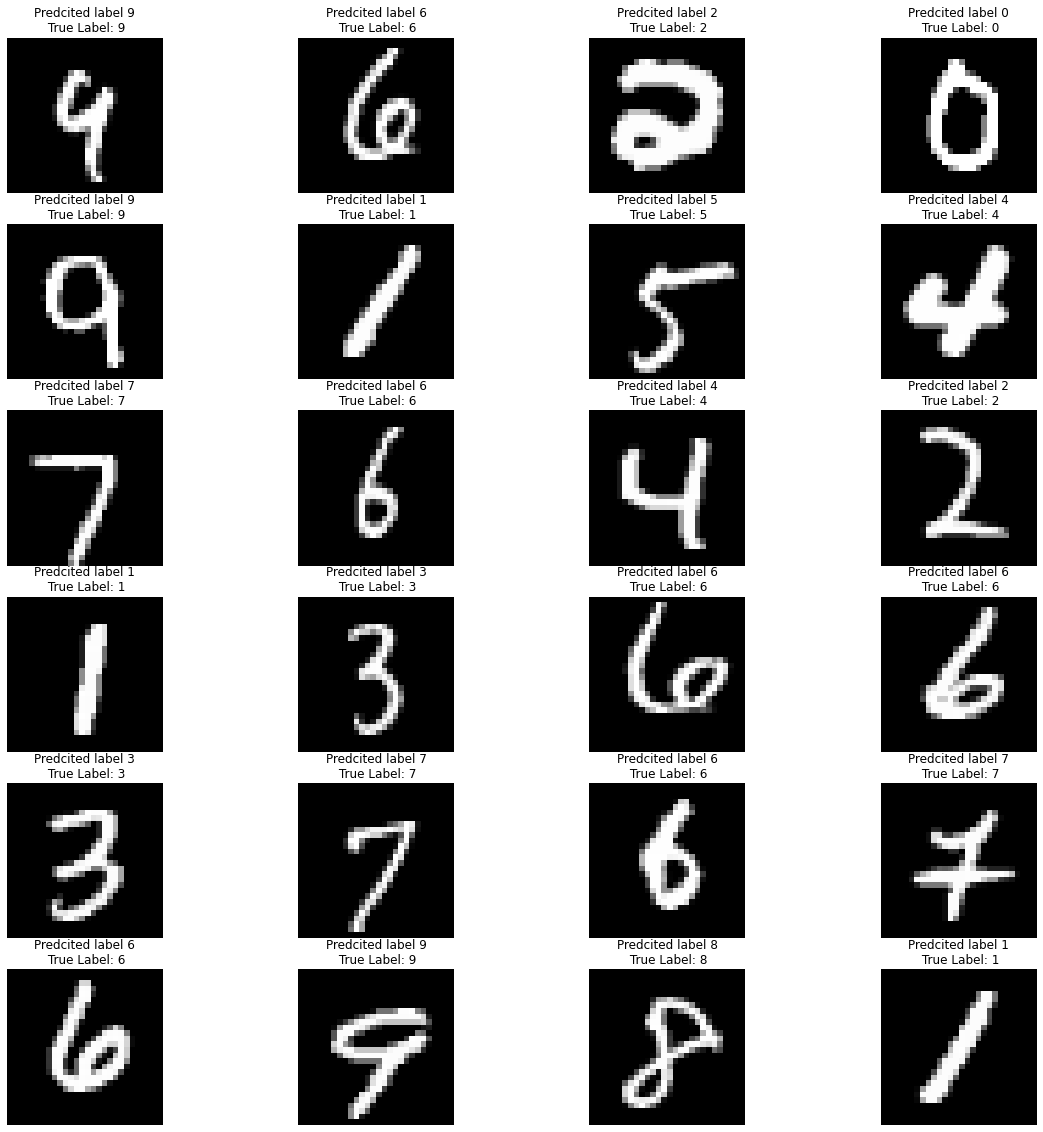

In [ ]:
cols, rows = 4,6
figure = plt.figure(figsize=(20, 20))
for i in range(1, cols * rows + 1):
    k = np.random.randint(0, len(test_loader.dataset)) # random points from test dataset
  
    img, label = test_loader.dataset[k] # separate the image and label
    img = img.unsqueeze(0) # adding one dimention
    pred=  model(img.to(device)) # Prediction 

    figure.add_subplot(rows, cols, i) # making the figure 
    plt.title(f"Predcited label {pred.argmax().item()}\n True Label: {label}") # title of plot
    plt.axis("off") # hiding the axis
    plt.imshow(img.squeeze(), cmap="gray") # showing the plot

plt.show()